# **TASK 1**

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.datasets import mnist

print('TensorFlow version:', tf.__version__)
print('Is Executing Eagerly?', tf.executing_eagerly())

TensorFlow version: 2.8.0
Is Executing Eagerly? True


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
import tensorflow as tf
from pathlib import Path
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input, InputLayer
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, LeakyReLU

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
    
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return self.output_layer(activation)
  
class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.relu)
  
    def call(self, code):
        activation = self.hidden_layer(code)
        return self.output_layer(activation)

class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, original_dim):
    super(Autoencoder, self).__init__()
    self.loss = []
    self.encoder = Encoder(intermediate_dim=intermediate_dim)
    self.decoder = Decoder(intermediate_dim=intermediate_dim, original_dim=original_dim)

  def call(self, input_features):
    code = self.encoder(input_features)
    reconstructed = self.decoder(code)
    return reconstructed

In [ ]:
def loss(preds, real):
  return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

In [ ]:
def train(loss, model, opt, original):
  with tf.GradientTape() as tape:
    preds = model(original)
    reconstruction_error = loss(preds, original)
  gradients = tape.gradient(reconstruction_error, model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)
  
  return reconstruction_error

In [ ]:
def train_loop(model, opt, loss, dataset, epochs):
  for epoch in range(epochs):
    epoch_loss = 0
    for step, batch_features in enumerate(dataset):
      loss_values = train(loss, model, opt, batch_features)
      epoch_loss += loss_values
    model.loss.append(epoch_loss)
    print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

In [ ]:
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train / 255.

x_test = x_test.astype('float32') / 255.

x_train = x_train.astype(np.float32)
x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))
print(x_train.shape)
training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(256)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 784)


In [ ]:
model = Autoencoder(intermediate_dim=32, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, 100)

Epoch 1/100. Loss: 8.943631172180176
Epoch 2/100. Loss: 6.453373432159424
Epoch 3/100. Loss: 6.025852680206299
Epoch 4/100. Loss: 5.807886123657227
Epoch 5/100. Loss: 5.717687606811523
Epoch 6/100. Loss: 5.654804706573486
Epoch 7/100. Loss: 5.61352014541626
Epoch 8/100. Loss: 5.571411609649658
Epoch 9/100. Loss: 5.5568695068359375
Epoch 10/100. Loss: 5.5465087890625
Epoch 11/100. Loss: 5.531641483306885
Epoch 12/100. Loss: 5.509035587310791
Epoch 13/100. Loss: 5.502599716186523
Epoch 14/100. Loss: 5.499816417694092
Epoch 15/100. Loss: 5.500263690948486
Epoch 16/100. Loss: 5.502395153045654
Epoch 17/100. Loss: 5.476592063903809
Epoch 18/100. Loss: 5.480245590209961
Epoch 19/100. Loss: 5.481032371520996
Epoch 20/100. Loss: 5.452208518981934
Epoch 21/100. Loss: 5.434187412261963
Epoch 22/100. Loss: 5.434566974639893
Epoch 23/100. Loss: 5.414159774780273
Epoch 24/100. Loss: 5.40339469909668
Epoch 25/100. Loss: 5.40867280960083
Epoch 26/100. Loss: 5.38737678527832
Epoch 27/100. Loss: 5.4094

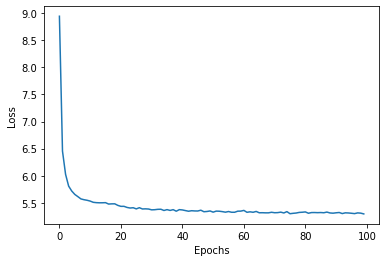

In [ ]:
plt.plot(range(len(model.loss)), model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

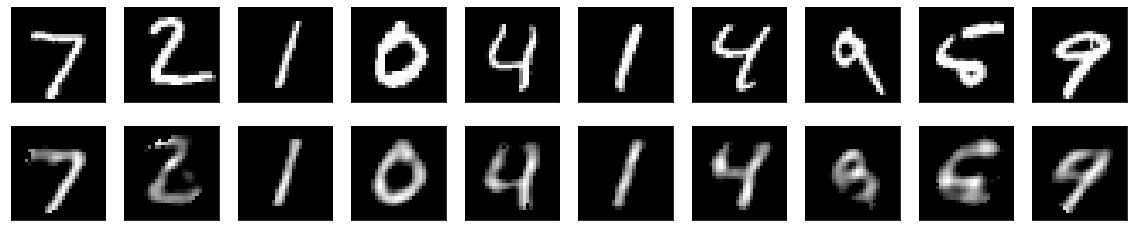

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Dense architecture 1

Epoch 1/100. Loss: 14.774876594543457
Epoch 2/100. Loss: 8.58272933959961
Epoch 3/100. Loss: 5.533311367034912
Epoch 4/100. Loss: 4.212672233581543
Epoch 5/100. Loss: 3.5068020820617676
Epoch 6/100. Loss: 3.0323143005371094
Epoch 7/100. Loss: 2.702439785003662
Epoch 8/100. Loss: 2.4706146717071533
Epoch 9/100. Loss: 2.2997868061065674
Epoch 10/100. Loss: 2.1540181636810303
Epoch 11/100. Loss: 1.9944273233413696
Epoch 12/100. Loss: 1.8746311664581299
Epoch 13/100. Loss: 1.7819021940231323
Epoch 14/100. Loss: 1.6891024112701416
Epoch 15/100. Loss: 1.6101042032241821
Epoch 16/100. Loss: 1.5440647602081299
Epoch 17/100. Loss: 1.5019580125808716
Epoch 18/100. Loss: 1.4797722101211548
Epoch 19/100. Loss: 1.435243844985962
Epoch 20/100. Loss: 1.382267713546753
Epoch 21/100. Loss: 1.3156113624572754
Epoch 22/100. Loss: 1.2655227184295654
Epoch 23/100. Loss: 1.2524269819259644
Epoch 24/100. Loss: 1.2526829242706299
Epoch 25/100. Loss: 1.2154462337493896
Epoch 26/100. Loss: 1.1589314937591553
Ep

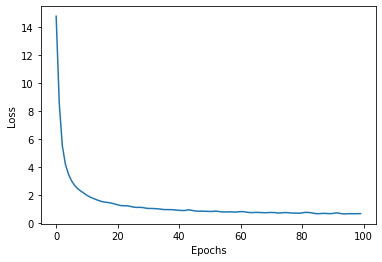

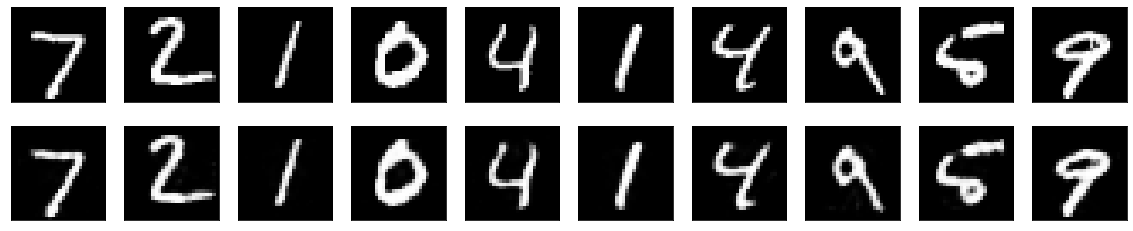

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.sigmoid)
        self.output_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.sigmoid)
    
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return self.output_layer(activation)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.sigmoid)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.sigmoid)
  
    def call(self, code):
        activation = self.hidden_layer(code)
        return self.output_layer(activation)

model = Autoencoder(intermediate_dim=128, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, 100)

plt.plot(range(len(model.loss)), model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


# Plot the images to see in training performance
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Dense architecture 2

Epoch 1/100. Loss: 14.684762001037598
Epoch 2/100. Loss: 6.604489803314209
Epoch 3/100. Loss: 3.8991339206695557
Epoch 4/100. Loss: 2.93975830078125
Epoch 5/100. Loss: 2.3093674182891846
Epoch 6/100. Loss: 1.9245150089263916
Epoch 7/100. Loss: 1.6860977411270142
Epoch 8/100. Loss: 1.5189272165298462
Epoch 9/100. Loss: 1.4097654819488525
Epoch 10/100. Loss: 1.3371894359588623
Epoch 11/100. Loss: 1.305406093597412
Epoch 12/100. Loss: 1.2614229917526245
Epoch 13/100. Loss: 1.1702015399932861
Epoch 14/100. Loss: 1.0998636484146118
Epoch 15/100. Loss: 1.0827792882919312
Epoch 16/100. Loss: 1.1075425148010254
Epoch 17/100. Loss: 1.0654429197311401
Epoch 18/100. Loss: 1.0081253051757812
Epoch 19/100. Loss: 0.9972761273384094
Epoch 20/100. Loss: 1.0103782415390015
Epoch 21/100. Loss: 1.0005762577056885
Epoch 22/100. Loss: 1.0155729055404663
Epoch 23/100. Loss: 0.9652760624885559
Epoch 24/100. Loss: 0.907749593257904
Epoch 25/100. Loss: 0.8317613005638123
Epoch 26/100. Loss: 0.8322951197624207


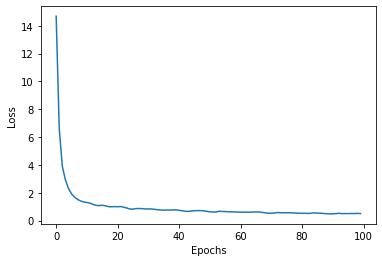

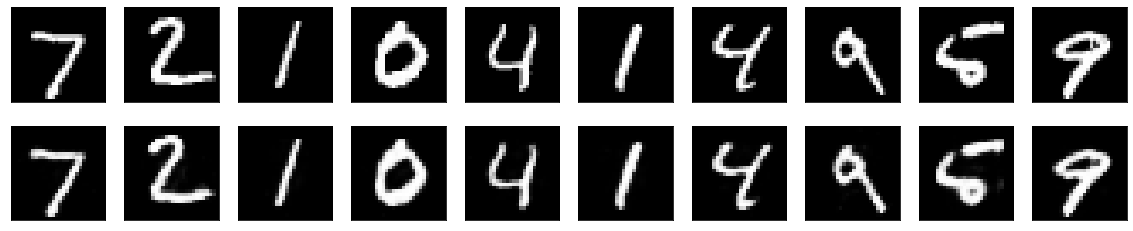

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim):
        super(Encoder, self).__init__()
        self.hidden_layer1 = tf.keras.layers.Dense(units=intermediate_dim , activation=tf.nn.softplus)
        self.output_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.softplus)
    
    def call(self, input_features):
        activation1 = self.hidden_layer1(input_features)
        return self.output_layer(activation1)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer1 = tf.keras.layers.Dense(units=intermediate_dim , activation=tf.nn.sigmoid)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.sigmoid)
  
    def call(self, code):
        activation1 = self.hidden_layer1(code)
        return self.output_layer(activation1)

model = Autoencoder(intermediate_dim=256, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, 100)

plt.plot(range(len(model.loss)), model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


# Plot the images to see in training performance
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Dense architecture 3

Epoch 1/100. Loss: 16.365863800048828
Epoch 2/100. Loss: 12.841841697692871
Epoch 3/100. Loss: 8.892512321472168
Epoch 4/100. Loss: 6.891735553741455
Epoch 5/100. Loss: 5.453381538391113
Epoch 6/100. Loss: 4.414378643035889
Epoch 7/100. Loss: 3.723156690597534
Epoch 8/100. Loss: 3.255612850189209
Epoch 9/100. Loss: 2.932061195373535
Epoch 10/100. Loss: 2.655585765838623
Epoch 11/100. Loss: 2.4482452869415283
Epoch 12/100. Loss: 2.3419992923736572
Epoch 13/100. Loss: 2.2868833541870117
Epoch 14/100. Loss: 2.213175058364868
Epoch 15/100. Loss: 2.042285919189453
Epoch 16/100. Loss: 1.8835067749023438
Epoch 17/100. Loss: 1.7548398971557617
Epoch 18/100. Loss: 1.6964164972305298
Epoch 19/100. Loss: 1.6452031135559082
Epoch 20/100. Loss: 1.6952006816864014
Epoch 21/100. Loss: 1.7608363628387451
Epoch 22/100. Loss: 1.7053685188293457
Epoch 23/100. Loss: 1.680138111114502
Epoch 24/100. Loss: 1.6615474224090576
Epoch 25/100. Loss: 1.6587051153182983
Epoch 26/100. Loss: 1.6716734170913696
Epoch 

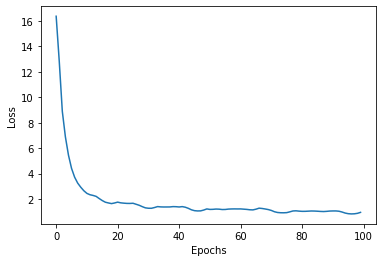

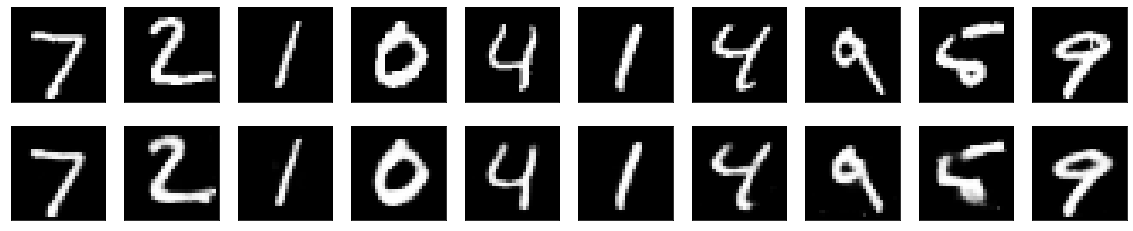

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim):
        super(Encoder, self).__init__()
        self.hidden_layer1 = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.sigmoid)
        self.hidden_layer2 = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.sigmoid)
        self.output_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.sigmoid)
    
    def call(self, input_features):
        activation1 = self.hidden_layer1(input_features)
        activation2 = self.hidden_layer2(activation1)
        return self.output_layer(activation2)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer1 = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.sigmoid)
        self.hidden_layer2 = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.sigmoid)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.sigmoid)
  
    def call(self, code):
        activation1 = self.hidden_layer1(code)
        activation2 = self.hidden_layer2(activation1)
        return self.output_layer(activation2)

model = Autoencoder(intermediate_dim=256, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, 100)

plt.plot(range(len(model.loss)), model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


# Plot the images to see in training performance
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## CNN 1

In [ ]:
input_img = tf.keras.layers.Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss= loss)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 up_sampling2d_3 (UpSampling  (None, 28, 28, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 1)         1153

In [ ]:

from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


In [ ]:
autoencoder.fit(x_train, x_train, epochs=100, batch_size=64, 
                shuffle=True, validation_data=(x_test, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])

Epoch 1/100
938/938 [==============================] - 18s 18ms/step - loss: 0.0038 - val_loss: 7.1129e-04
Epoch 2/100
938/938 [==============================] - 17s 18ms/step - loss: 6.0282e-04 - val_loss: 5.3276e-04
Epoch 3/100
938/938 [==============================] - 16s 18ms/step - loss: 4.6986e-04 - val_loss: 4.1287e-04
Epoch 4/100
938/938 [==============================] - 16s 18ms/step - loss: 3.8875e-04 - val_loss: 3.4412e-04
Epoch 5/100
938/938 [==============================] - 17s 18ms/step - loss: 3.3541e-04 - val_loss: 3.2482e-04
Epoch 6/100
938/938 [==============================] - 16s 18ms/step - loss: 2.9740e-04 - val_loss: 2.7131e-04
Epoch 7/100
938/938 [==============================] - 17s 18ms/step - loss: 2.6933e-04 - val_loss: 2.4938e-04
Epoch 8/100
938/938 [==============================] - 16s 17ms/step - loss: 2.4796e-04 - val_loss: 2.2946e-04
Epoch 9/100
938/938 [==============================] - 17s 18ms/step - loss: 2.2859e-04 - val_loss: 2.1249e-04
Epoch

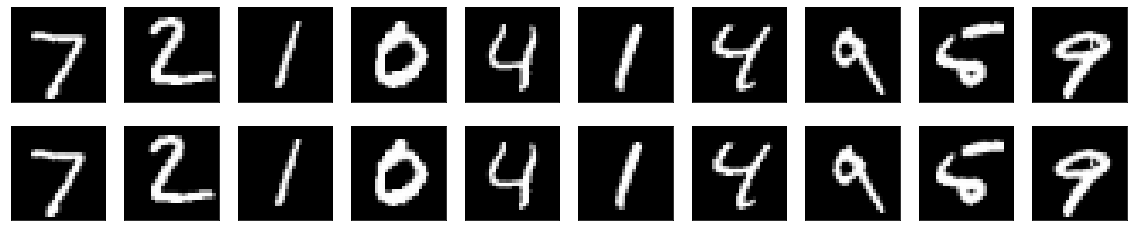

In [ ]:
decoded_imgs = autoencoder.predict(x_test)
# Plot the images to see in training performance
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## CNN Complex Model 1

In [ ]:
from keras import regularizers

encoding_dim = 32

input_img = tf.keras.layers.Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = tf.keras.layers.Dense(encoding_dim, activation = 'relu', 
                                activity_regularizer = regularizers.l2(0.01))(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='Adam', loss= loss)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 7, 7, 8)           584 

In [ ]:
# to train this model we will with original MNIST digits with shape (samples, 3, 28, 28) and we will just normalize pixel values between 0 and 1
# (x_train, _), (x_test, _) = load_data('../input/mnist.npz')
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
#x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
#x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [ ]:
autoencoder.fit(x_train, x_train, epochs=100, batch_size=128, 
                shuffle=True, validation_data=(x_test, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])

Epoch 1/100
469/469 [==============================] - 9s 15ms/step - loss: 0.0702 - val_loss: 0.0376
Epoch 2/100
469/469 [==============================] - 6s 13ms/step - loss: 0.0318 - val_loss: 0.0266
Epoch 3/100
469/469 [==============================] - 6s 12ms/step - loss: 0.0245 - val_loss: 0.0223
Epoch 4/100
469/469 [==============================] - 6s 12ms/step - loss: 0.0213 - val_loss: 0.0197
Epoch 5/100
469/469 [==============================] - 6s 13ms/step - loss: 0.0193 - val_loss: 0.0183
Epoch 6/100
469/469 [==============================] - 6s 12ms/step - loss: 0.0180 - val_loss: 0.0172
Epoch 7/100
469/469 [==============================] - 6s 12ms/step - loss: 0.0172 - val_loss: 0.0164
Epoch 8/100
469/469 [==============================] - 6s 13ms/step - loss: 0.0165 - val_loss: 0.0158
Epoch 9/100
469/469 [==============================] - 6s 13ms/step - loss: 0.0160 - val_loss: 0.0154
Epoch 10/100
469/469 [==============================] - 6s 13ms/step - loss: 0.015

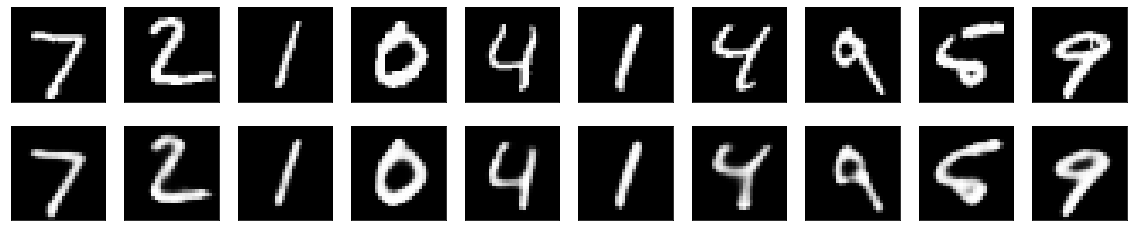

In [ ]:
decoded_imgs = autoencoder.predict(x_test)
# Plot the images to see in training performance
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## CNN Complex Model 2

In [ ]:
from keras import regularizers

encoding_dim = 32
input_img = tf.keras.layers.Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format
#input_img = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Conv2D(16, (3, 3), activation='softplus', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='softplus', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='softplus', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
encoded = tf.keras.layers.Dense(encoding_dim, activation = 'relu', activity_regularizer = regularizers.l1(10e-5))(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(8, (3, 3), activation='softplus', padding='same')(encoded)
x = BatchNormalization()(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='softplus', padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='softplus')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='Adam', loss=loss)

In [ ]:
autoencoder.fit(x_train, x_train, epochs=100, batch_size=128, 
                shuffle=True, validation_data=(x_test, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])

Epoch 1/100
469/469 [==============================] - 10s 18ms/step - loss: 0.0637 - val_loss: 0.0751
Epoch 2/100
469/469 [==============================] - 7s 15ms/step - loss: 0.0213 - val_loss: 0.0225
Epoch 3/100
469/469 [==============================] - 7s 15ms/step - loss: 0.0165 - val_loss: 0.0177
Epoch 4/100
469/469 [==============================] - 7s 15ms/step - loss: 0.0144 - val_loss: 0.0156
Epoch 5/100
469/469 [==============================] - 7s 15ms/step - loss: 0.0131 - val_loss: 0.0144
Epoch 6/100
469/469 [==============================] - 8s 16ms/step - loss: 0.0122 - val_loss: 0.0133
Epoch 7/100
469/469 [==============================] - 7s 15ms/step - loss: 0.0116 - val_loss: 0.0125
Epoch 8/100
469/469 [==============================] - 7s 15ms/step - loss: 0.0110 - val_loss: 0.0125
Epoch 9/100
469/469 [==============================] - 7s 15ms/step - loss: 0.0107 - val_loss: 0.0120
Epoch 10/100
469/469 [==============================] - 7s 14ms/step - loss: 0.01

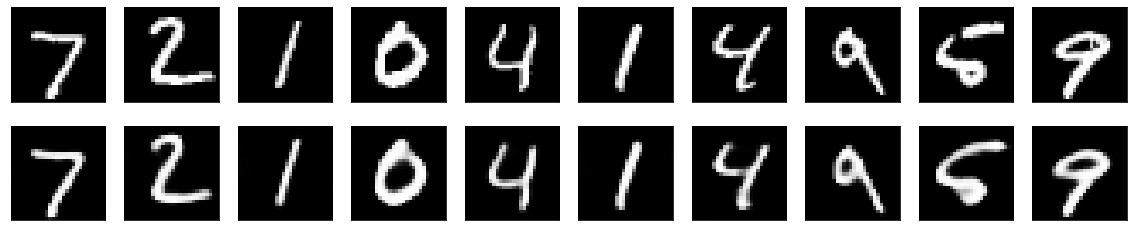

In [ ]:
decoded_imgs = autoencoder.predict(x_test)
# Plot the images to see in training performance
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# **TASK 2 : Denoising**

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.).astype('float32')
x_test_noisy = np.clip(x_test_noisy, 0., 1.).astype('float32')


print(x_train_noisy.shape)

(60000, 28, 28, 1)


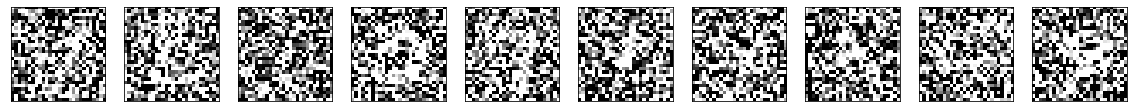

In [ ]:
# Plot figures to show what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Dense 1

(60000, 784)
Epoch 1/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0695 - val_loss: 0.0676
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0652 - val_loss: 0.0621
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0594 - val_loss: 0.0580
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0565 - val_loss: 0.0554
Epoch 5/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0548 - val_loss: 0.0544
Epoch 6/100
469/469 [==============================] - 7s 15ms/step - loss: 0.0521 - val_loss: 0.0498
Epoch 7/100
469/469 [==============================] - 6s 14ms/step - loss: 0.0487 - val_loss: 0.0475
Epoch 8/100
469/469 [==============================] - 5s 11ms/step - loss: 0.0463 - val_loss: 0.0457
Epoch 9/100
469/469 [==============================] - 6s 12ms/step - loss: 0.0446 - val_loss: 0.0443
Epoch 10/100
469/469 [==============================] - 4s 9ms/step - loss

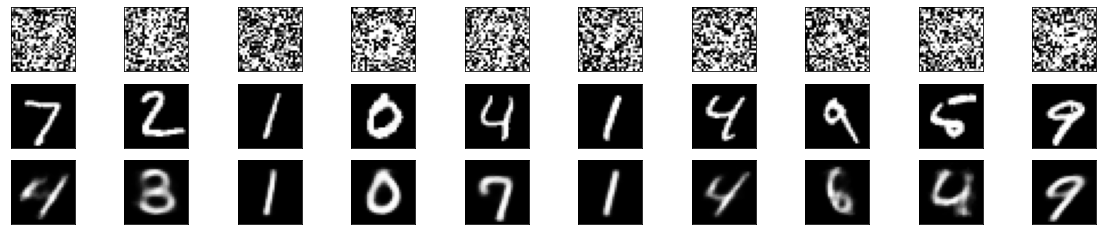

In [ ]:
x_train_noisy = np.reshape(x_train_noisy,(x_train_noisy.shape[0], 784))
print(x_train_noisy.shape)
x_test_noisy = np.reshape(x_test_noisy,(x_test_noisy.shape[0], 784))
x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test,(x_test.shape[0], 784))

class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim):
        super(Encoder, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=512, activation=tf.nn.sigmoid)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=512, activation=tf.nn.sigmoid)
        self.hidden_layer_3 = tf.keras.layers.Dense(units=512, activation=tf.nn.sigmoid)
        self.output_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.sigmoid)
    
    def call(self, input_features):
        activation1 = self.hidden_layer_1(input_features)
        activation2 = self.hidden_layer_2(activation1)
        activation3 = self.hidden_layer_3(activation2)
        return self.output_layer(activation3)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=512, activation=tf.nn.relu)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=512, activation = tf.nn.relu)
        self.hidden_layer_3 = tf.keras.layers.Dense(units=512, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.sigmoid)
  
    def call(self, code):
        activation1 = self.hidden_layer_1(code)
        activation2 = self.hidden_layer_2(activation1)
        activation3 = self.hidden_layer_3(activation2)
        return self.output_layer(activation3)

model = Autoencoder(intermediate_dim=128, original_dim=784)
model.compile(loss= loss , optimizer = 'adam')

model.fit(x_train_noisy, x_train, epochs=100, batch_size=128, 
                shuffle=True, validation_data=(x_test_noisy, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/tb', histogram_freq=0, write_graph=False)])



number = 10 
plt.figure(figsize=(20, 4))
for index in range(number):
    
    # display noisy
    ax = plt.subplot(3, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original
    ax = plt.subplot(3, number, index + 1 + number)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, number, index + 1 + (2 * number))
    plt.imshow(model(x_test_noisy)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## CNN

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Introduce noise with a probability factor of 0.5
noise_factor = 0.5
x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.).astype('float32')
x_test_noisy = np.clip(x_test_noisy, 0., 1.).astype('float32')


print(x_train_noisy.shape)

(60000, 28, 28, 1)


Epoch 1/100
469/469 [==============================] - 17s 20ms/step - loss: 0.2324 - val_loss: 0.2258
Epoch 2/100
469/469 [==============================] - 9s 19ms/step - loss: 0.2181 - val_loss: 0.2087
Epoch 3/100
469/469 [==============================] - 9s 19ms/step - loss: 0.1904 - val_loss: 0.1666
Epoch 4/100
469/469 [==============================] - 10s 22ms/step - loss: 0.1407 - val_loss: 0.1250
Epoch 5/100
469/469 [==============================] - 9s 19ms/step - loss: 0.1187 - val_loss: 0.1175
Epoch 6/100
469/469 [==============================] - 9s 19ms/step - loss: 0.1147 - val_loss: 0.1155
Epoch 7/100
469/469 [==============================] - 10s 20ms/step - loss: 0.1132 - val_loss: 0.1144
Epoch 8/100
469/469 [==============================] - 13s 28ms/step - loss: 0.1122 - val_loss: 0.1134
Epoch 9/100
469/469 [==============================] - 11s 23ms/step - loss: 0.1112 - val_loss: 0.1125
Epoch 10/100
469/469 [==============================] - 9s 19ms/step - loss: 

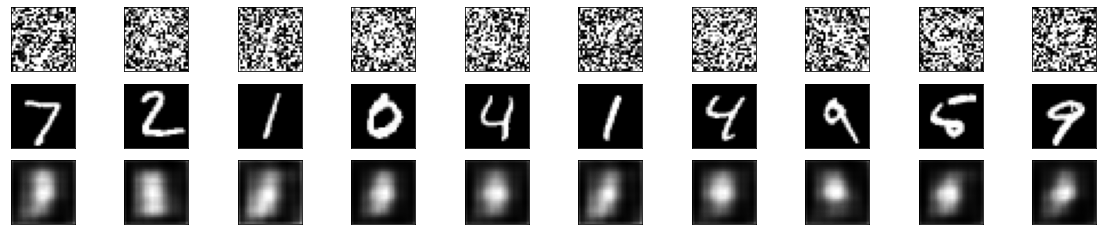

In [ ]:
input_img = tf.keras.layers.Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss= loss)

autoencoder.fit(x_train_noisy, x_train, epochs=100, batch_size=128, 
                shuffle=True, validation_data=(x_test_noisy, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])

decoded_imgs = autoencoder.predict(x_test)
# Plot the images to see in training performance
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    
    # display noisy
    ax = plt.subplot(3, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original
    ax = plt.subplot(3, number, index + 1 + number)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, number, index + 1 + (2 * number))
    plt.imshow(decoded_imgs[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## CNN 2

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0   

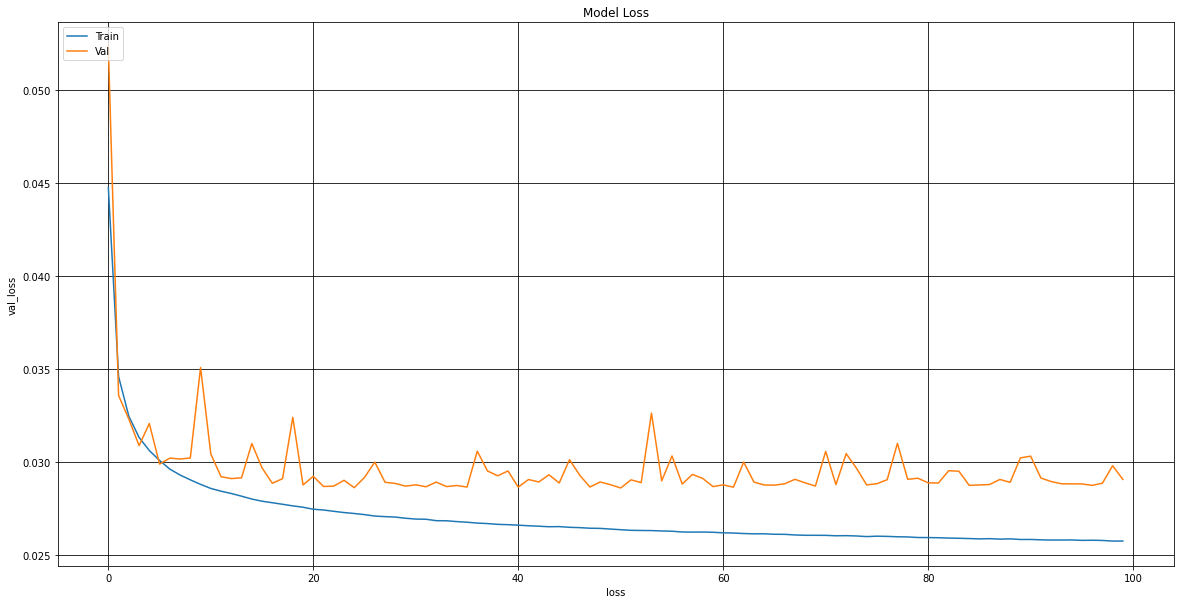

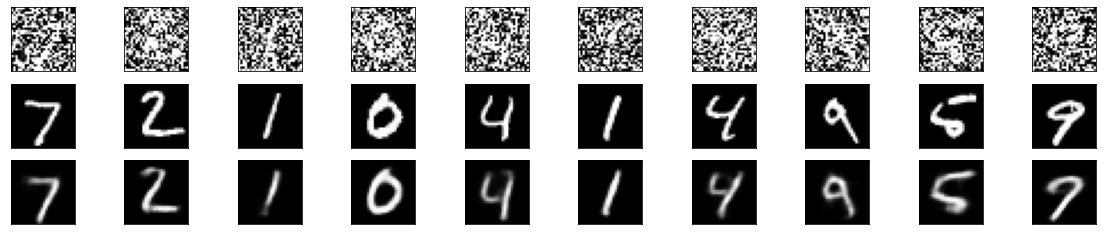

In [ ]:

#!tensorboard --logdir=/tmp/autoencoder --bind_all
input_img = tf.keras.layers.Input(shape=(28, 28, 1))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# Adam(learning_rate=0.001)
autoencoder.compile(optimizer='adam', loss= loss)

autoencoder.summary()

model = autoencoder.fit(x_train_noisy, x_train, epochs=100, batch_size=128, 
                shuffle=True, validation_data=(x_test_noisy, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])

decoded_imgs = autoencoder.predict(x_test)
plot_loss(model)
# Plot the images to see in training performance
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    
    # display noisy
    ax = plt.subplot(3, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original
    ax = plt.subplot(3, number, index + 1 + number)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, number, index + 1 + (2 * number))
    plt.imshow(decoded_imgs[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# **TASK 3 : Text Reconstruction**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
import tensorflow as tf
from pathlib import Path
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input, InputLayer
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split

In [ ]:
np.random.seed(111)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
   
train_data_dir = Path('/datasets/train/')
train_cleaned_data_dir = Path('/datasets/train_cleaned')
test_data_dir = Path('/datasets/test')
# Train dataset
!wget -cP /datasets/ "https://github.com/gmprovan/CS6421-Assignment1/raw/master/train.zip"
# Train labels
!wget -cP /datasets/ "https://github.com/gmprovan/CS6421-Assignment1/raw/master/train_cleaned.zip"

# Test dataset
!wget -cP /datasets/ "https://github.com/gmprovan/CS6421-Assignment1/raw/master/test.zip"
#!ls
!unzip /datasets/train.zip -d /datasets/
!unzip /datasets/train_cleaned.zip -d /datasets/
!unzip /datasets/test.zip -d /datasets/
#data_dir ="train.zip"
print(train_data_dir)
print(list(train_data_dir.glob('**/*.png')))
image_count = len(list(train_data_dir.glob('**/*.png')))
print(image_count)

--2022-03-28 10:49:13--  https://github.com/gmprovan/CS6421-Assignment1/raw/master/train.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gmprovan/CS6421-Assignment1/master/train.zip [following]
--2022-03-28 10:49:13--  https://raw.githubusercontent.com/gmprovan/CS6421-Assignment1/master/train.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19407030 (19M) [application/zip]
Saving to: ‘/datasets/train.zip’

train.zip           100%[===================>]  18.51M  --.-KB/s    in 0.1s    

2022-03-28 10:49:14 (126 MB/s) - ‘/datasets/train.zip’ saved [19407030/19407030]

--2022-03-28 10:49:14-

## DENSE

In [ ]:
import tensorflow as tf
# Define Auto Encoder
# Encoder
input_img = Input(shape=(420,540,1))
encoded = Dense(64, activation='relu')(input_img)
encoded = Dense(32, activation='relu')(encoded)

# Decoder
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(1, activation='sigmoid')(decoded)
autoencoder = Model(input_img, decoded)
optim = Adam(learning_rate=5e-3)
def loss(preds, real):
  return tf.reduce_mean(tf.square(tf.subtract(preds, real)))




autoencoder.compile(optimizer=optim, loss = loss)
autoencoder.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 dense_32 (Dense)            (None, 420, 540, 64)      128       
                                                                 
 dense_33 (Dense)            (None, 420, 540, 32)      2080      
                                                                 
 dense_34 (Dense)            (None, 420, 540, 32)      1056      
                                                                 
 dense_35 (Dense)            (None, 420, 540, 64)      2112      
                                                                 
 dense_36 (Dense)            (None, 420, 540, 1)       65        
                                                                 
Total params: 5,441
Trainable params: 5,441
Non-trainable p

In [ ]:
X = []
Y = []
x_test = []
train_images = os.listdir(train_data_dir)
train_labels = os.listdir(train_cleaned_data_dir)
test_images = os.listdir(test_data_dir) 
for img in train_images:
    img = load_img(train_data_dir /img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)
 
for img in train_labels:
    img = load_img(train_cleaned_data_dir/ img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)
 
for img in test_images:
    img = load_img(test_data_dir/ img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    #img = img_to_array(img)
    x_test.append(img)
 
X = np.array(X)
Y = np.array(Y)
x_test = np.array(x_test)
 
print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)
print("Size of Z : ", x_test.shape)

# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)
 
# Train your model
autoencoder.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)
Size of Z :  (72, 420, 540, 1)
Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)
Epoch 1/100
17/17 [==============================] - 6s 306ms/step - loss: 0.1011 - val_loss: 0.0584
Epoch 2/100
17/17 [==============================] - 5s 284ms/step - loss: 0.0466 - val_loss: 0.0311
Epoch 3/100
17/17 [==============================] - 5s 291ms/step - loss: 0.0215 - val_loss: 0.0089
Epoch 4/100
17/17 [==============================] - 5s 284ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 5/100
17/17 [==============================] - 5s 294ms/step - loss: 0.0074 - val_loss: 0.0045
Epoch 6/100
17/17 [==============================] - 5s 292ms/step - loss: 0.0053 - val_loss: 0.0040
Epoch 7/100
17/17 [==============================] - 5s 299ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 8/100
17/17 [==============================] - 5s 301ms/step - loss: 0.0061 - val_l

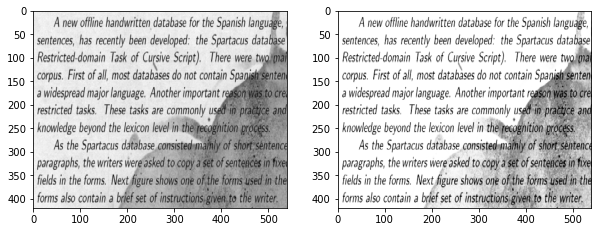

In [ ]:
sample_test = x_test[0]
#print(sample_test.shape)
sample_test_img = np.expand_dims(sample_test, axis=0)
#print(sample_test_img.shape)
# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))
#print(predicted_label)
f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label), cmap='gray')
plt.show()

## CNN 1

In [ ]:
input_img = tf.keras.layers.Input(shape=(420, 540, 1)) # adapt this if using `channels_first` image data format

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss= loss )
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 420, 540, 128)     1280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 210, 270, 128)    0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 210, 270, 64)      73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 105, 135, 64)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 105, 135, 32)      1846

In [ ]:
X = []
Y = []
x_test = []
train_images = os.listdir(train_data_dir)
train_labels = os.listdir(train_cleaned_data_dir)
test_images = os.listdir(test_data_dir)
print(len(train_labels))
#raise Exception
for img in train_images:
    img = load_img(train_data_dir / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned_data_dir / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)
  
for img in test_images:
    img = load_img(test_data_dir / img, grayscale=True, target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    x_test.append(img)


X = np.array(X)
Y = np.array(Y)
x_test = np.array(x_test)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)
print("Size of Test : ", x_test.shape)

# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

# Train your model
#autoencoder.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_valid, y_valid))


144


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)
Size of Test :  (72, 420, 540, 1)
Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


Epoch 1/100
17/17 [==============================] - 19s 836ms/step - loss: 0.0593 - val_loss: 0.0434
Epoch 2/100
17/17 [==============================] - 10s 617ms/step - loss: 0.0433 - val_loss: 0.0366
Epoch 3/100
17/17 [==============================] - 11s 633ms/step - loss: 0.0360 - val_loss: 0.0334
Epoch 4/100
17/17 [==============================] - 11s 634ms/step - loss: 0.0338 - val_loss: 0.0314
Epoch 5/100
17/17 [==============================] - 11s 633ms/step - loss: 0.0327 - val_loss: 0.0311
Epoch 6/100
17/17 [==============================] - 11s 624ms/step - loss: 0.0317 - val_loss: 0.0309
Epoch 7/100
17/17 [==============================] - 11s 633ms/step - loss: 0.0305 - val_loss: 0.0286
Epoch 8/100
17/17 [==============================] - 11s 625ms/step - loss: 0.0291 - val_loss: 0.0277
Epoch 9/100
17/17 [==============================] - 11s 635ms/step - loss: 0.0281 - val_loss: 0.0287
Epoch 10/100
17/17 [==============================] - 11s 623ms/step - loss: 0.027

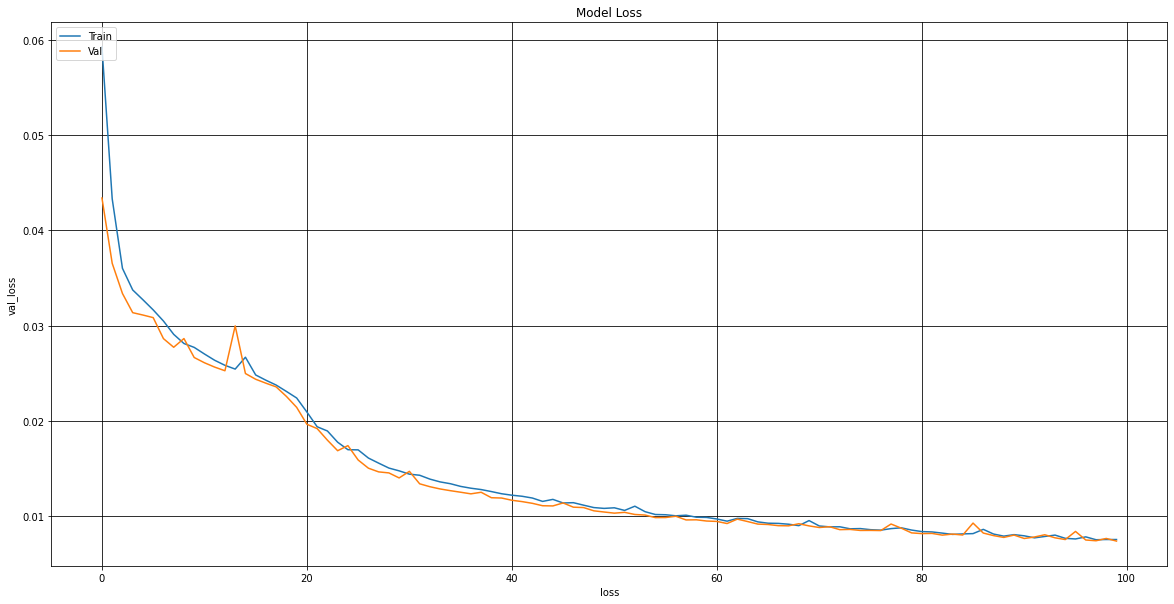

In [ ]:
def plot_loss(model, x = 'loss', y = 'val_loss'): 
 fig, ax = plt.subplots( figsize=(20,10)) 
 ax.plot(model.history[x]) 
 ax.plot(model.history[y]) 
 plt.title('Model Loss') 
 plt.ylabel(y) 
 plt.xlabel(x) 
 plt.legend(['Train', 'Val'], loc='upper left') 
 ax.grid(color='black') 
 plt.show() 
model = autoencoder.fit(X_train, X_train, epochs=100, batch_size=8, 
                shuffle=True, validation_data=(X_valid, X_valid), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])
plot_loss(model)

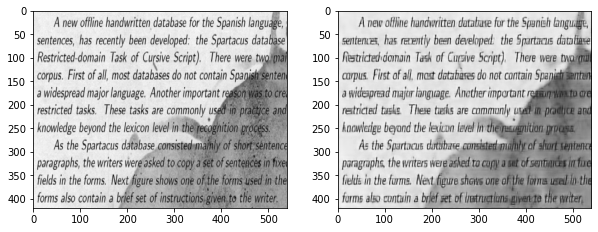

In [ ]:
sample_test = x_test[0]

sample_test_img = np.expand_dims(sample_test, axis=0)

predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label), cmap='gray')
plt.show()

## CNN Complex

In [ ]:
# Lets' define our autoencoder now
np.random.seed(111)
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, LeakyReLU


# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

def plot_loss(model, x = 'loss', y = 'val_loss'): 
 fig, ax = plt.subplots( figsize=(20,10)) 
 ax.plot(model.history[x]) 
 ax.plot(model.history[y]) 
 plt.title('Model Loss') 
 plt.ylabel(y) 
 plt.xlabel(x) 
 plt.legend(['Train', 'Val'], loc='upper left') 
 ax.grid(color='black') 
 plt.show() 

def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    x = Conv2D(64, (3, 3), padding='same')(input_img)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), padding='same')(encoded)
    x = Activation('relu')(x)
    x = Conv2D(64, (3,3), padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(1,(3,3), padding = 'same')(x)
    decoded = Activation('sigmoid')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=decoded)
    tf.keras.optimizers.Adam(learning_rate = 0.00001)
    autoencoder.compile(optimizer='adam', loss=loss, )
    return autoencoder

autoencoder = build_autoenocder()
autoencoder.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_48 (Conv2D)          (None, 420, 540, 64)      640       
                                                                 
 activation_32 (Activation)  (None, 420, 540, 64)      0         
                                                                 
 conv2d_49 (Conv2D)          (None, 420, 540, 128)     73856     
                                                                 
 activation_33 (Activation)  (None, 420, 540, 128)     0         
                                                                 
 batch_normalization_34 (Bat  (None, 420, 540, 128)    512       
 chNormalization)                                                
                                                           

Epoch 1/100
65/65 [==============================] - 26s 400ms/step - loss: 0.0372 - val_loss: 0.0688
Epoch 2/100
65/65 [==============================] - 21s 327ms/step - loss: 0.0126 - val_loss: 0.0701
Epoch 3/100
65/65 [==============================] - 21s 327ms/step - loss: 0.0063 - val_loss: 0.0716
Epoch 4/100
65/65 [==============================] - 21s 320ms/step - loss: 0.0044 - val_loss: 0.0705
Epoch 5/100
65/65 [==============================] - 21s 320ms/step - loss: 0.0032 - val_loss: 0.0726
Epoch 6/100
65/65 [==============================] - 21s 327ms/step - loss: 0.0020 - val_loss: 0.0701
Epoch 7/100
65/65 [==============================] - 21s 327ms/step - loss: 0.0018 - val_loss: 0.0614
Epoch 8/100
65/65 [==============================] - 21s 320ms/step - loss: 0.0017 - val_loss: 0.0458
Epoch 9/100
65/65 [==============================] - 21s 320ms/step - loss: 0.0016 - val_loss: 0.0343
Epoch 10/100
65/65 [==============================] - 21s 320ms/step - loss: 0.001

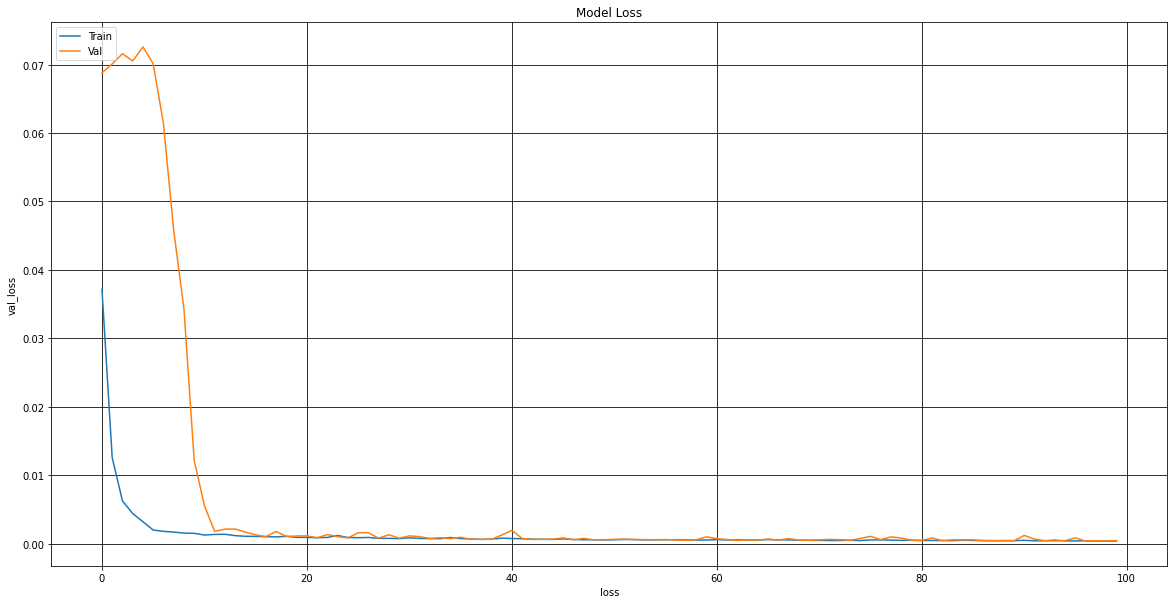

In [ ]:
#callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
# Train your model
model = autoencoder.fit(X_train, y_train, epochs=100, batch_size=2, validation_data=(X_valid, y_valid))
plot_loss(model)
#plot_loss(model, x = 'root_mean_squared_error', y='val_root_mean_squared_error')


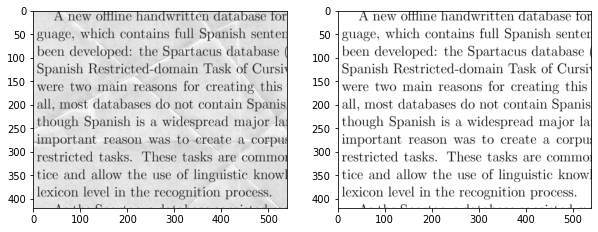

In [ ]:
sample_test = x_test[5]
#print(sample_test.shape)
sample_test_img = np.expand_dims(sample_test, axis=0)
#print(sample_test_img.shape)
#Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))
#print(predicted_label)
f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label), cmap='gray')
plt.show()

## CNN Complex 2

In [ ]:
X = []
Y = []
x_test = []
train_images = os.listdir(train_data_dir)
train_labels = os.listdir(train_cleaned_data_dir)
test_images = os.listdir(test_data_dir)
print(len(train_labels))
#raise Exception
for img in train_images:
    img = load_img(train_data_dir / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned_data_dir / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)
  
for img in test_images:
    img = load_img(test_data_dir / img, grayscale=True, target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    x_test.append(img)


X = np.array(X)
Y = np.array(Y)
x_test = np.array(x_test)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)
print("Size of Test : ", x_test.shape)

# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

# Train your model
#autoencoder.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_valid, y_valid))


144


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)
Size of Test :  (72, 420, 540, 1)
Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


In [ ]:
# Lets' define our autoencoder now

import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation


def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    # Encoder
    x = Conv2D(64, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('leaky_relu')(x)
    x = MaxPooling2D((3, 3), padding='same')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    encoded = Activation('leaky_relu')(x)

    # Decoder
    x = Conv2D(128, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('leaky_relu')(x)
    x = UpSampling2D((3, 3))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('leaky_relu')(x)
    x = Conv2D(1, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Activation('sigmoid')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=decoded)
    tf.keras.optimizers.Adam(learning_rate = 0.01)
    autoencoder.compile(optimizer='adam', loss=loss)
    return autoencoder

autoencoder = build_autoenocder()
autoencoder.summary()


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_53 (Conv2D)          (None, 420, 540, 64)      640       
                                                                 
 batch_normalization_36 (Bat  (None, 420, 540, 64)     256       
 chNormalization)                                                
                                                                 
 activation_37 (Activation)  (None, 420, 540, 64)      0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 140, 180, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 140, 180, 128)     738

In [ ]:
autoencoder.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid))

Epoch 1/100
17/17 [==============================] - 18s 1s/step - loss: 0.1723 - val_loss: 0.1923
Epoch 2/100
17/17 [==============================] - 17s 1s/step - loss: 0.1506 - val_loss: 0.1632
Epoch 3/100
17/17 [==============================] - 17s 1s/step - loss: 0.1429 - val_loss: 0.1570
Epoch 4/100
17/17 [==============================] - 17s 1s/step - loss: 0.1374 - val_loss: 0.1488
Epoch 5/100
17/17 [==============================] - 18s 1s/step - loss: 0.1326 - val_loss: 0.1414
Epoch 6/100
17/17 [==============================] - 17s 1s/step - loss: 0.1283 - val_loss: 0.1426
Epoch 7/100
17/17 [==============================] - 17s 1s/step - loss: 0.1246 - val_loss: 0.1574
Epoch 8/100
17/17 [==============================] - 17s 1s/step - loss: 0.1211 - val_loss: 0.1345
Epoch 9/100
17/17 [==============================] - 17s 1s/step - loss: 0.1175 - val_loss: 0.1382
Epoch 10/100
17/17 [==============================] - 18s 1s/step - loss: 0.1141 - val_loss: 0.1372
Epoch 11/

[[0.8521688  0.8828651  0.8511425  ... 0.8682068  0.8793624  0.84156376]
 [0.8449441  0.8757728  0.8686525  ... 0.8740549  0.8810902  0.8752089 ]
 [0.8399432  0.8883377  0.8551163  ... 0.87168723 0.8453546  0.88538474]
 ...
 [0.86088914 0.85029805 0.86484367 ... 0.86424726 0.8576737  0.7887597 ]
 [0.84502536 0.8108758  0.8832118  ... 0.86373097 0.86742747 0.63935614]
 [0.8392736  0.8341987  0.8788059  ... 0.79699856 0.7653063  0.6669285 ]]


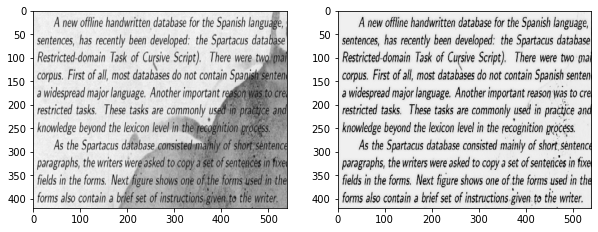

In [ ]:


# Compute the prediction
predicted_label = np.squeeze(autoencoder.predict(x_test, batch_size=8))
print(predicted_label[0].reshape(420, 540))
#raise Exception
f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(x_test[0]), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label[0].reshape(420, 540)), cmap='gray')
plt.show()

